In [2]:
#Importing needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import glob
import datetime as dt
import datetime
from math import floor
import struct

####Importing geopsatial libraries
import fiona
from shapely.geometry import shape, mapping, Point, Polygon
from shapely import wkt
import rtree
import fiona.crs
import geopandas as gpd
import pyproj
from osgeo import gdal,ogr


#### Importing Raster Libraries
import rasterio
import rioxarray as rxr
from rasterio.plot import plotting_extent
import rasterstats as rs

####Ignoring Warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
#### Loading the master dataset 
facilities_data = pd.read_csv('/Users/akashyadav/Desktop/facilities_risk/data/master_data_2021_07_02.csv')

#### Removing unnamed colums
facilities_data = facilities_data.drop(columns=['Unnamed: 0'])

#### Converting to geodataframe
geometry = [Point(xy) for xy in zip(facilities_data.LONGITUDE, facilities_data.LATITUDE)]
facilities_data = gpd.GeoDataFrame(facilities_data, crs="EPSG:4326", geometry=geometry)

#### Re-initializing with CRS 3857 for creating buffers in miles
facilities_data = facilities_data.to_crs({'init': 'epsg:3857'})  
facilities_data.head()

,LICENSED_CERTIFIED,FLAG,T18_19,FACID,FAC_STATUS_TYPE_CODE,ASPEN_FACID,CCN,TERMINAT_SW,PARTICIPATION_DATE,APPROVAL_DATE,...,CCLHO_NAME,FIPS_COUNTY_CODE,BIRTHING_FACILITY_FLAG,TRAUMA_PED_CTR,TRAUMA_CTR,TYPE_OF_CARE,CRITICAL_ACCESS_HOSPITAL,DATA_DATE,geometry,is_within_muap
0,LICENSED AND CERTIFIED,USE PARENT MATCH,NaN,30000301,OPEN,CA030000146,050127,NaN,1966-07-01 00:00:00,2019-08-13 00:00:00,...,YOLO,6113,NaN,NaN,NaN,NaN,NaN,2021-06-08 00:00:00,POINT (-13557837.004 4673661.232),False
1,LICENSED AND CERTIFIED,USE PARENT MATCH,NaN,60000673,OPEN,CA060000067,050069,NaN,1966-07-01 00:00:00,2020-09-23 00:00:00,...,ORANGE,6059,NaN,NaN,NaN,NaN,NaN,2021-06-08 00:00:00,POINT (-13120664.658 3999583.585),False
2,LICENSED AND CERTIFIED,USE PARENT MATCH,NaN,60000697,OPEN,CA060000027,050376,NaN,1966-07-01 00:00:00,2020-05-15 00:00:00,...,LOS ANGELES,6037,NaN,NaN,NaN,NaN,NaN,2021-06-08 00:00:00,POINT (-13168508.217 4005970.352),False
3,LICENSED AND CERTIFIED,USE PARENT MATCH,NaN,60000700,OPEN,CA060000040,050373,NaN,1966-07-01 00:00:00,2018-01-04 00:00:00,...,LOS ANGELES,6037,NaN,NaN,NaN,NaN,NaN,2021-06-08 00:00:00,POINT (-13158874.183 4036814.916),False
4,LICENSED AND CERTIFIED,USE PARENT MATCH,NaN,70000288,OPEN,CA070000137,050145,NaN,1966-07-01 00:00:00,2019-08-15 00:00:00,...,MONTEREY,6053,NaN,NaN,NaN,NaN,NaN,2021-06-08 00:00:00,POINT (-13571541.164 4380608.548),False


In [ ]:
#### Saving as geojson
facilities_data.to_file('facilities_data.geojson', driver='GeoJSON')

In [12]:
#### Creating 1 km buffers around facilities
facilities_data_buffers = facilities_data.to_crs({'init': 'epsg:3857'})  
buffer_length_in_meters = 1609.34
facilities_data_buffers['geometry'] = facilities_data_buffers.geometry.buffer(buffer_length_in_meters)
facilities_data_buffers.head()

,LICENSED_CERTIFIED,FLAG,T18_19,FACID,FAC_STATUS_TYPE_CODE,ASPEN_FACID,CCN,TERMINAT_SW,PARTICIPATION_DATE,APPROVAL_DATE,...,BIRTHING_FACILITY_FLAG,TRAUMA_PED_CTR,TRAUMA_CTR,TYPE_OF_CARE,CRITICAL_ACCESS_HOSPITAL,DATA_DATE,geometry,is_within_muap,directly_within_ftz_value,is_directly_within_ftz
0,LICENSED AND CERTIFIED,USE PARENT MATCH,NaN,30000301,OPEN,CA030000146,050127,NaN,1966-07-01 00:00:00,2019-08-13 00:00:00,...,NaN,NaN,NaN,NaN,NaN,2021-06-08 00:00:00,"POLYGON ((-13556227.664 4673661.232, -13556235...",False,0.0,1
1,LICENSED AND CERTIFIED,USE PARENT MATCH,NaN,60000673,OPEN,CA060000067,050069,NaN,1966-07-01 00:00:00,2020-09-23 00:00:00,...,NaN,NaN,NaN,NaN,NaN,2021-06-08 00:00:00,"POLYGON ((-13119055.318 3999583.585, -13119063...",False,NaN,0
2,LICENSED AND CERTIFIED,USE PARENT MATCH,NaN,60000697,OPEN,CA060000027,050376,NaN,1966-07-01 00:00:00,2020-05-15 00:00:00,...,NaN,NaN,NaN,NaN,NaN,2021-06-08 00:00:00,"POLYGON ((-13166898.877 4005970.352, -13166906...",False,NaN,0
3,LICENSED AND CERTIFIED,USE PARENT MATCH,NaN,60000700,OPEN,CA060000040,050373,NaN,1966-07-01 00:00:00,2018-01-04 00:00:00,...,NaN,NaN,NaN,NaN,NaN,2021-06-08 00:00:00,"POLYGON ((-13157264.843 4036814.916, -13157272...",False,NaN,0
4,LICENSED AND CERTIFIED,USE PARENT MATCH,NaN,70000288,OPEN,CA070000137,050145,NaN,1966-07-01 00:00:00,2019-08-15 00:00:00,...,NaN,NaN,NaN,NaN,NaN,2021-06-08 00:00:00,"POLYGON ((-13569931.824 4380608.548, -13569939...",False,NaN,0


Text(0.5, 1.0, '1 mile buffers')

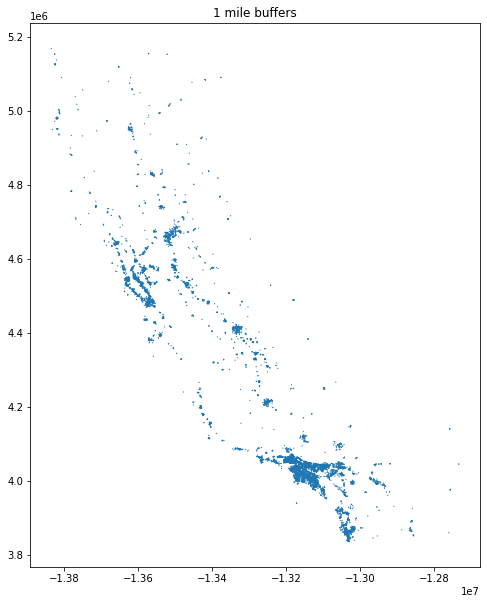

In [13]:
fig, ax = plt.subplots(1, figsize=(10, 10))
facilities_data_buffers.plot(ax=ax)
plt.title('1 mile buffers')

In [14]:
#### Loading raster data
wildfire_threat = rxr.open_rasterio('fthrt14_2.tif', masked=True).squeeze()

In [15]:
#### Reprojecting the raster
wildfire_threat = wildfire_threat.rio.reproject(facilities_data_buffers.crs)

In [16]:
#### Spatial Matching raster with facolities data and extracting summary stats
facilities_threat = rs.zonal_stats(facilities_data_buffers,
                                   wildfire_threat.values,
                                   nodata=-128,
                                   affine=wildfire_threat.rio.transform(),
                                   geojson_out=True,
                                   copy_properties=True,
                                   stats="count min mean max median")

In [17]:
#### Converting spatial matches to geodataframe
facilities_threat_buffers = gpd.GeoDataFrame.from_features(facilities_threat, crs="EPSG:3857")
facilities_threat_buffers.head()

,geometry,ADDRESS,AO_CD,AO_NAME,AO_TRMNTN_DT,APPROVAL_DATE,ASPEN_FACID,BIRTHING_FACILITY_FLAG,BUSINESS_NAME,CAN_BE_CERTIFIED_FAC_TYPE,...,ZIP,ZIP9,directly_within_ftz_value,is_directly_within_ftz,is_within_muap,min,max,mean,count,median
0,"POLYGON ((-13556227.664 4673661.232, -13556235...",1325 COTTONWOOD STREET,1.0,JC,None,2019-08-13 00:00:00,CA030000146,None,DIGNITY COMMUNITY CARE,Y,...,95695,5131,0.0,1,False,0.0,0.0,0.000000,5015,0.0
1,"POLYGON ((-13119055.318 3999583.585, -13119063...",1100 W STEWART DR,1.0,JC,None,2020-09-23 00:00:00,CA060000067,None,ST. JOSEPH HOSPITAL OF ORANGE,Y,...,92868,3849,NaN,0,False,1.0,2.0,1.953271,107,2.0
2,"POLYGON ((-13166898.877 4005970.352, -13166906...",1000 W CARSON ST,1.0,JC,None,2020-05-15 00:00:00,CA060000027,None,LOS ANGELES COUNTY DEPARTMENT OF HEALTH SERVICES,Y,...,90502,2004,NaN,0,False,NaN,NaN,NaN,0,NaN
3,"POLYGON ((-13157264.843 4036814.916, -13157272...",1200 N STATE ST,1.0,JC,None,2018-01-04 00:00:00,CA060000040,None,LOS ANGELES COUNTY DEPARTMENT OF HEALTH SERVICES,Y,...,90033,1029,NaN,0,False,2.0,2.0,2.000000,87,2.0
4,"POLYGON ((-13569931.824 4380608.548, -13569939...",23625 W.R. HOLMAN HWY,1.0,JC,None,2019-08-15 00:00:00,CA070000137,None,COMMUNITY HOSPITAL OF THE MONTEREY PENINSULA,Y,...,93940,5902,NaN,0,False,2.0,3.0,2.015896,4152,2.0


In [18]:
#### Renaming columns
facilities_threat_buffers = facilities_threat_buffers.rename(columns={'min':'ftz_min_threat_within_buffer',
                                                                     'max':'ftz_max_threat_within_buffer',
                                                                     'count':'ftz_pixel_counts_within_buffer',
                                                                     'mean':'ftz_avg_severity_within_buffer',
                                                                     'median':'ftz_median_severity_within_buffer'})
facilities_threat_buffers.head()

,geometry,ADDRESS,AO_CD,AO_NAME,AO_TRMNTN_DT,APPROVAL_DATE,ASPEN_FACID,BIRTHING_FACILITY_FLAG,BUSINESS_NAME,CAN_BE_CERTIFIED_FAC_TYPE,...,ZIP,ZIP9,directly_within_ftz_value,is_directly_within_ftz,is_within_muap,ftz_min_threat_within_buffer,ftz_max_threat_within_buffer,ftz_avg_severity_within_buffer,ftz_pixel_counts_within_buffer,ftz_median_severity_within_buffer
0,"POLYGON ((-13556227.664 4673661.232, -13556235...",1325 COTTONWOOD STREET,1.0,JC,None,2019-08-13 00:00:00,CA030000146,None,DIGNITY COMMUNITY CARE,Y,...,95695,5131,0.0,1,False,0.0,0.0,0.000000,5015,0.0
1,"POLYGON ((-13119055.318 3999583.585, -13119063...",1100 W STEWART DR,1.0,JC,None,2020-09-23 00:00:00,CA060000067,None,ST. JOSEPH HOSPITAL OF ORANGE,Y,...,92868,3849,NaN,0,False,1.0,2.0,1.953271,107,2.0
2,"POLYGON ((-13166898.877 4005970.352, -13166906...",1000 W CARSON ST,1.0,JC,None,2020-05-15 00:00:00,CA060000027,None,LOS ANGELES COUNTY DEPARTMENT OF HEALTH SERVICES,Y,...,90502,2004,NaN,0,False,NaN,NaN,NaN,0,NaN
3,"POLYGON ((-13157264.843 4036814.916, -13157272...",1200 N STATE ST,1.0,JC,None,2018-01-04 00:00:00,CA060000040,None,LOS ANGELES COUNTY DEPARTMENT OF HEALTH SERVICES,Y,...,90033,1029,NaN,0,False,2.0,2.0,2.000000,87,2.0
4,"POLYGON ((-13569931.824 4380608.548, -13569939...",23625 W.R. HOLMAN HWY,1.0,JC,None,2019-08-15 00:00:00,CA070000137,None,COMMUNITY HOSPITAL OF THE MONTEREY PENINSULA,Y,...,93940,5902,NaN,0,False,2.0,3.0,2.015896,4152,2.0


In [19]:
#### Binary FTZ column creation function
def is_within_ftz_buffer(row):
    if row['ftz_pixel_counts_within_buffer'] == 0:
        val = 0
    else:
        val = 1
    return val

#### Creating binary column for facility within threat
facilities_threat_buffers['is_within_ftz_buffer'] = facilities_threat_buffers.apply(is_within_ftz_buffer, axis=1)
facilities_threat_buffers.head()

,geometry,ADDRESS,AO_CD,AO_NAME,AO_TRMNTN_DT,APPROVAL_DATE,ASPEN_FACID,BIRTHING_FACILITY_FLAG,BUSINESS_NAME,CAN_BE_CERTIFIED_FAC_TYPE,...,ZIP9,directly_within_ftz_value,is_directly_within_ftz,is_within_muap,ftz_min_threat_within_buffer,ftz_max_threat_within_buffer,ftz_avg_severity_within_buffer,ftz_pixel_counts_within_buffer,ftz_median_severity_within_buffer,is_within_ftz_buffer
0,"POLYGON ((-13556227.664 4673661.232, -13556235...",1325 COTTONWOOD STREET,1.0,JC,None,2019-08-13 00:00:00,CA030000146,None,DIGNITY COMMUNITY CARE,Y,...,5131,0.0,1,False,0.0,0.0,0.000000,5015,0.0,1
1,"POLYGON ((-13119055.318 3999583.585, -13119063...",1100 W STEWART DR,1.0,JC,None,2020-09-23 00:00:00,CA060000067,None,ST. JOSEPH HOSPITAL OF ORANGE,Y,...,3849,NaN,0,False,1.0,2.0,1.953271,107,2.0,1
2,"POLYGON ((-13166898.877 4005970.352, -13166906...",1000 W CARSON ST,1.0,JC,None,2020-05-15 00:00:00,CA060000027,None,LOS ANGELES COUNTY DEPARTMENT OF HEALTH SERVICES,Y,...,2004,NaN,0,False,NaN,NaN,NaN,0,NaN,0
3,"POLYGON ((-13157264.843 4036814.916, -13157272...",1200 N STATE ST,1.0,JC,None,2018-01-04 00:00:00,CA060000040,None,LOS ANGELES COUNTY DEPARTMENT OF HEALTH SERVICES,Y,...,1029,NaN,0,False,2.0,2.0,2.000000,87,2.0,1
4,"POLYGON ((-13569931.824 4380608.548, -13569939...",23625 W.R. HOLMAN HWY,1.0,JC,None,2019-08-15 00:00:00,CA070000137,None,COMMUNITY HOSPITAL OF THE MONTEREY PENINSULA,Y,...,5902,NaN,0,False,2.0,3.0,2.015896,4152,2.0,1


Text(0.5, 1.0, 'Average Severity within 1 Mile buffers')

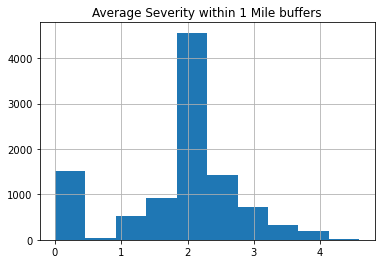

In [21]:
#### Plotting severity zones
facilities_threat_buffers['ftz_avg_severity_within_buffer'].hist()
plt.title('Average Severity within 1 Mile buffers')